In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
path_prefix = './cs5228-2310-final-project/'
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')

In [3]:
df_train.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


## Data Preprocessing

In [4]:
#data clean
df_train.isnull().sum()

rent_approval_date     0
town                   0
block                  0
street_name            0
flat_type              0
flat_model             0
floor_area_sqm         0
furnished              0
lease_commence_date    0
latitude               0
longitude              0
elevation              0
subzone                0
planning_area          0
region                 0
monthly_rent           0
dtype: int64

In [5]:
df_train.dtypes

rent_approval_date      object
town                    object
block                   object
street_name             object
flat_type               object
flat_model              object
floor_area_sqm         float64
furnished               object
lease_commence_date      int64
latitude               float64
longitude              float64
elevation              float64
subzone                 object
planning_area           object
region                  object
monthly_rent             int64
dtype: object

In [6]:
df_stock = pd.read_csv(path_prefix + 'auxiliary-data/auxiliary-data/sg-stock-prices.csv')
df_stock['date'] = pd.to_datetime(df_stock['date'])
df_stock['date'] = pd.to_datetime(df_stock['date'])
df_stock['date'] = df_stock['date'].dt.strftime('%Y-%m')
avg_adjusted_close = df_stock.groupby(['date'])['adjusted_close'].mean().reset_index()
df_train = pd.merge(df_train, avg_adjusted_close, left_on='rent_approval_date', right_on='date')
df_train.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,date,adjusted_close
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600,2021-09,15.448564
1,2021-09,punggol,203a,punggol field,4 room,model a,85.0,yes,2004,1.398524,103.903863,0.0,matilda,punggol,north-east region,2400,2021-09,15.448564
2,2021-09,choa chu kang,458,choa chu kang avenue 4,executive,premium apartment,142.0,yes,2000,1.378101,103.736002,0.0,peng siang,choa chu kang,west region,1800,2021-09,15.448564
3,2021-09,sembawang,340a,sembawang close,5 room,premium apartment,110.0,yes,2001,1.447534,103.817892,0.0,sembawang central,sembawang,north region,2100,2021-09,15.448564
4,2021-09,bishan,117,bishan street 12,5 room,improved,121.0,yes,1987,1.347017,103.849987,0.0,bishan east,bishan,central region,2750,2021-09,15.448564


In [96]:
df_coe = pd.read_csv(path_prefix + 'auxiliary-data/auxiliary-data/sg-coe-prices.csv')
month_to_numeric = {
    'january': 1,
    'february': 2,
    'march': 3,
    'april': 4,
    'may': 5,
    'june': 6,
    'july': 7,
    'august': 8,
    'september': 9,
    'october': 10,
    'november': 11,
    'december': 12
}

df_coe['month'] = df_coe['month'].apply(lambda x: month_to_numeric[x.lower()])
df_coe['month'] = df_coe['month'].apply(lambda x: f'{x:02d}')

df_coe['date'] = df_coe['year'].astype(str) + '-' + df_coe['month']

df_coe['date_c'] = df_coe['date'].astype(str) + '-' + df_coe['category'].astype(str)

avg_price_bids_quota = df_coe.groupby('date_c').agg({
  'price': 'mean',
  'bids': 'mean',
  'quota': 'mean'
}).reset_index()



avg_price_bids_quota['date'] = avg_price_bids_quota['date_c'].str[:-2]  # Extract the date part
avg_price_bids_quota['category'] = avg_price_bids_quota['date_c'].str[-1]

avg_price_bids_quota['bids_quota_ratio'] = avg_price_bids_quota['bids'] / avg_price_bids_quota['quota']

avg_price_bids_quota.drop(columns=['date_c'], inplace=True)
print(avg_price_bids_quota)
for c in avg_price_bids_quota['category'].unique():
    filtered_data = avg_price_bids_quota[avg_price_bids_quota['category'] == c]
    original_column_names = filtered_data.columns.tolist()
    new_column_names = ['price'+c, 'bids'+c, 'quota'+c, 'date'+c, 'c'+c, 'bids_quota_ratio'+c]
    # print(new_column_names)
    rename_dict = {original_column_names[i]: new_column_names[i] for i in range(len(original_column_names))}
    filtered_data = filtered_data.rename(columns=rename_dict)
    print(filtered_data)
    filtered_data = filtered_data.reset_index()
    df_train = pd.merge(df_train, filtered_data[['c'+c, 'bids'+c, 'quota'+c, 'date'+c, 'price'+c, 'bids_quota_ratio'+c]], left_on='rent_approval_date', right_on='date'+c)
    
    
#df_train = pd.merge(df_train, avg_price_bids_quota[['date', 'price', 'category', 'bids_quota_ratio']], left_on='rent_approval_date', right_on='date')
df_train.head()

        price    bids   quota     date category  bids_quota_ratio
0     42055.0  1294.5   964.5  2021-01        a          1.342146
1     49550.5  1367.0  1020.5  2021-01        b          1.339539
2     38449.5   675.0   376.5  2021-01        c          1.792829
3     50694.5   731.5   466.5  2021-01        e          1.568060
4     41500.5  1162.0   894.0  2021-02        a          1.299776
..        ...     ...     ...      ...      ...               ...
119  121944.5   296.0   134.5  2023-06        e          2.200743
120   96101.0   742.0   584.5  2023-07        a          1.269461
121  118001.5   598.0   466.5  2023-07        b          1.281886
122   82112.0   140.0    73.0  2023-07        c          1.917808
123  121555.0   230.0   129.5  2023-07        e          1.776062

[124 rows x 6 columns]
       pricea   bidsa  quotaa    datea ca  bids_quota_ratioa
0     42055.0  1294.5   964.5  2021-01  a           1.342146
4     41500.5  1162.0   894.0  2021-02  a           1.299776
8

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,quotac,datec,pricec,bids_quota_ratioc,ce,bidse,quotae,datee,pricee,bids_quota_ratioe
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,...,121.0,2021-09,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703
1,2021-09,punggol,203a,punggol field,4 room,model a,85.0,yes,2004,1.398524,...,121.0,2021-09,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703
2,2021-09,choa chu kang,458,choa chu kang avenue 4,executive,premium apartment,142.0,yes,2000,1.378101,...,121.0,2021-09,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703
3,2021-09,sembawang,340a,sembawang close,5 room,premium apartment,110.0,yes,2001,1.447534,...,121.0,2021-09,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703
4,2021-09,bishan,117,bishan street 12,5 room,improved,121.0,yes,1987,1.347017,...,121.0,2021-09,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703


In [27]:
df_train.drop(columns=['date_x', 'date_y'], inplace=True)

In [97]:
df_train.describe()
df_train['rent_approval_date'] = pd.to_datetime(df_train['rent_approval_date'])
df_train['rent_approval_year'] = df_train['rent_approval_date'].dt.year
df_train['rent_approval_month'] = df_train['rent_approval_date'].dt.month/12 + df_train['rent_approval_date'].dt.year

In [98]:
df_train

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,pricec,bids_quota_ratioc,ce,bidse,quotae,datee,pricee,bids_quota_ratioe,rent_approval_year,rent_approval_month
0,2021-09-01,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,...,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75
1,2021-09-01,punggol,203a,punggol field,4 room,model a,85.0,yes,2004,1.398524,...,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75
2,2021-09-01,choa chu kang,458,choa chu kang avenue 4,executive,premium apartment,142.0,yes,2000,1.378101,...,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75
3,2021-09-01,sembawang,340a,sembawang close,5 room,premium apartment,110.0,yes,2001,1.447534,...,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75
4,2021-09-01,bishan,117,bishan street 12,5 room,improved,121.0,yes,1987,1.347017,...,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2022-09-01,bukit panjang,623,Senja Road,5-room,improved,110.0,yes,2001,1.386256,...,65995.0,2.000000,e,278.5,170.5,2022-09,110250.0,1.633431,2022,2022.75
59996,2022-09-01,geylang,102,Aljunied Crescent,3-room,new generation,82.0,yes,1978,1.320481,...,65995.0,2.000000,e,278.5,170.5,2022-09,110250.0,1.633431,2022,2022.75
59997,2022-09-01,bishan,443,sin ming avenue,4-room,model a,105.0,yes,1990,1.358948,...,65995.0,2.000000,e,278.5,170.5,2022-09,110250.0,1.633431,2022,2022.75
59998,2022-09-01,jurong east,227,jurong east street 21,5-room,improved,120.0,yes,1984,1.341821,...,65995.0,2.000000,e,278.5,170.5,2022-09,110250.0,1.633431,2022,2022.75


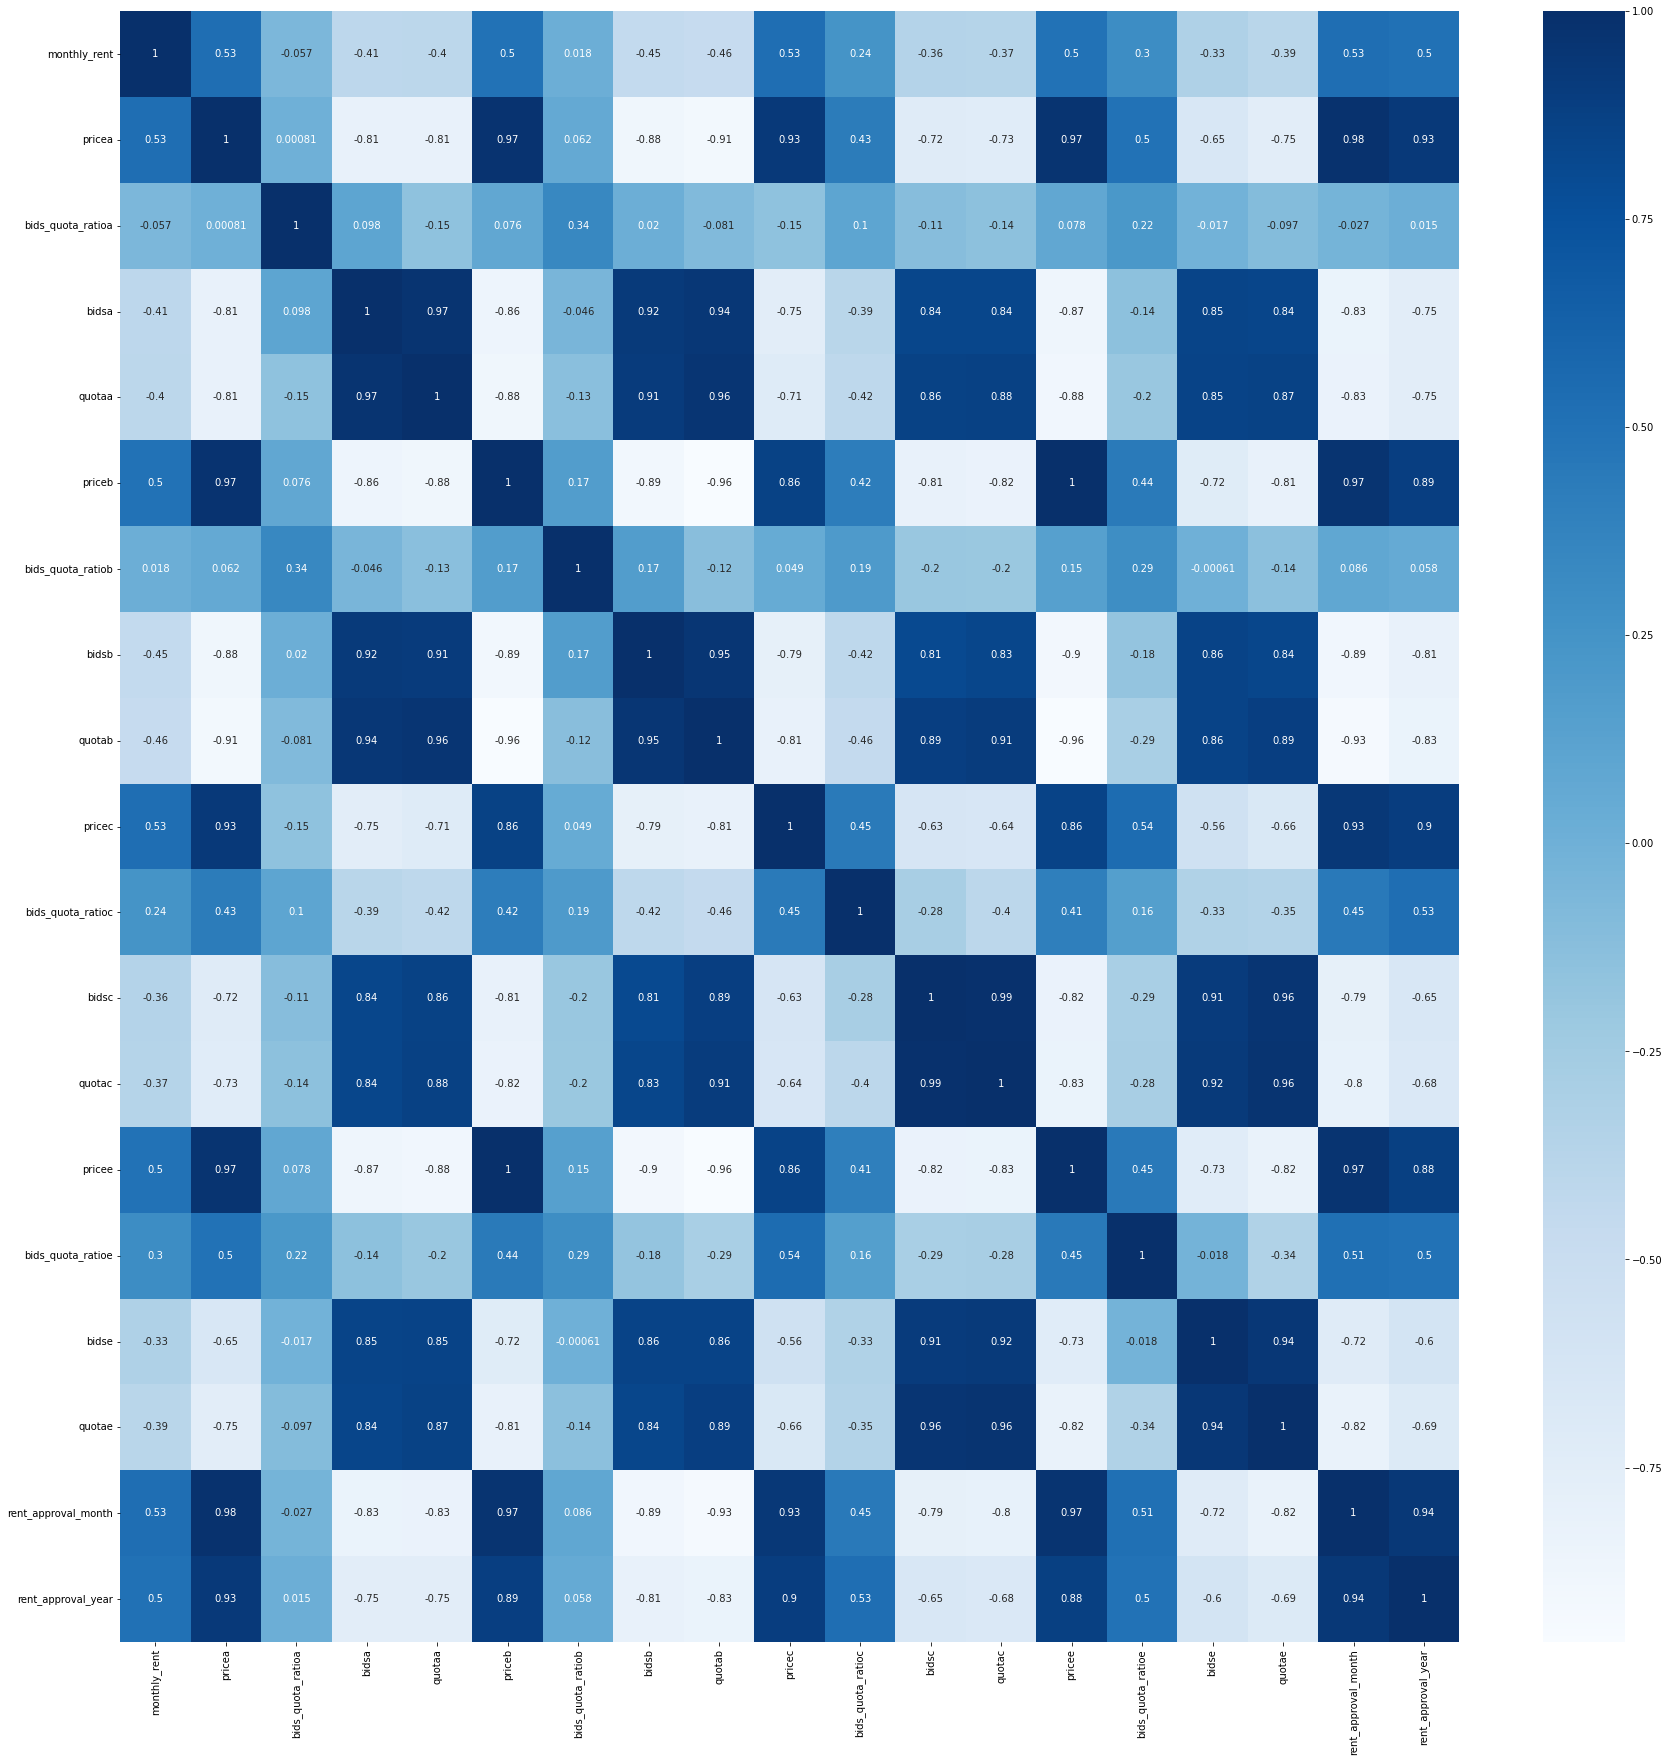

In [106]:
#draw corr heatmap
corr = df_train[['monthly_rent','pricea', 'bids_quota_ratioa', 'bidsa', 'quotaa', 'priceb', 'bids_quota_ratiob', 'bidsb', 'quotab','pricec', 'bids_quota_ratioc', 'bidsc', 'quotac','pricee', 'bids_quota_ratioe', 'bidse', 'quotae', 'rent_approval_month', 'rent_approval_year']].corr()#[['floor_area_sqm', 'lease_commence_date', 'rent_approval_year', 'rent_approval_month', 'adjusted_close', 'price', 'bids_quota_ratio', 'flat_model', 'monthly_rent']].corr()
sns.heatmap(corr, annot=True, cmap='Blues')

fig = plt.gcf()
fig.set_size_inches(30, 30)  # 设置图的大小，单位为英寸

# 显示图
plt.show()


In [91]:
df_train.describe()

,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,monthly_rent,adjusted_close,price,bids_quota_ratio,rent_approval_year,rent_approval_month
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.0,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,94.480458,1990.876367,1.359443,103.840110,0.0,2590.328333,11.872900,75173.627058,1.476214,2021.813050,2022.299508
std,24.082642,12.141435,0.042505,0.071627,0.0,714.910468,2.506630,21312.751456,0.080382,0.780006,0.758707
min,34.000000,1966.000000,1.270380,103.685228,0.0,300.000000,8.983589,43812.000000,1.344763,2021.000000,2021.083333
25%,73.000000,1981.000000,1.330939,103.778803,0.0,2100.000000,9.487512,52199.625000,1.419904,2021.000000,2021.666667
50%,93.000000,1988.000000,1.354024,103.845301,0.0,2400.000000,11.224848,77035.625000,1.456284,2022.000000,2022.250000
75%,110.000000,2000.000000,1.386968,103.897418,0.0,3000.000000,13.856788,96230.250000,1.533866,2022.000000,2023.000000
max,215.000000,2019.000000,1.457071,103.964915,0.0,6950.000000,17.422356,105592.375000,1.664336,2023.000000,2023.583333


In [93]:
#draw corr distribution plot
sns.pairplot(df_train[['floor_area_sqm', 'lease_commence_date', 'rent_approval_year', 'rent_approval_month', 'adjusted_close', 'price', 'bids_quota_ratio', 'monthly_rent']], diag_kind='kde', kind='reg')


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f96fbbfcca0> (for post_execute):


KeyboardInterrupt: 

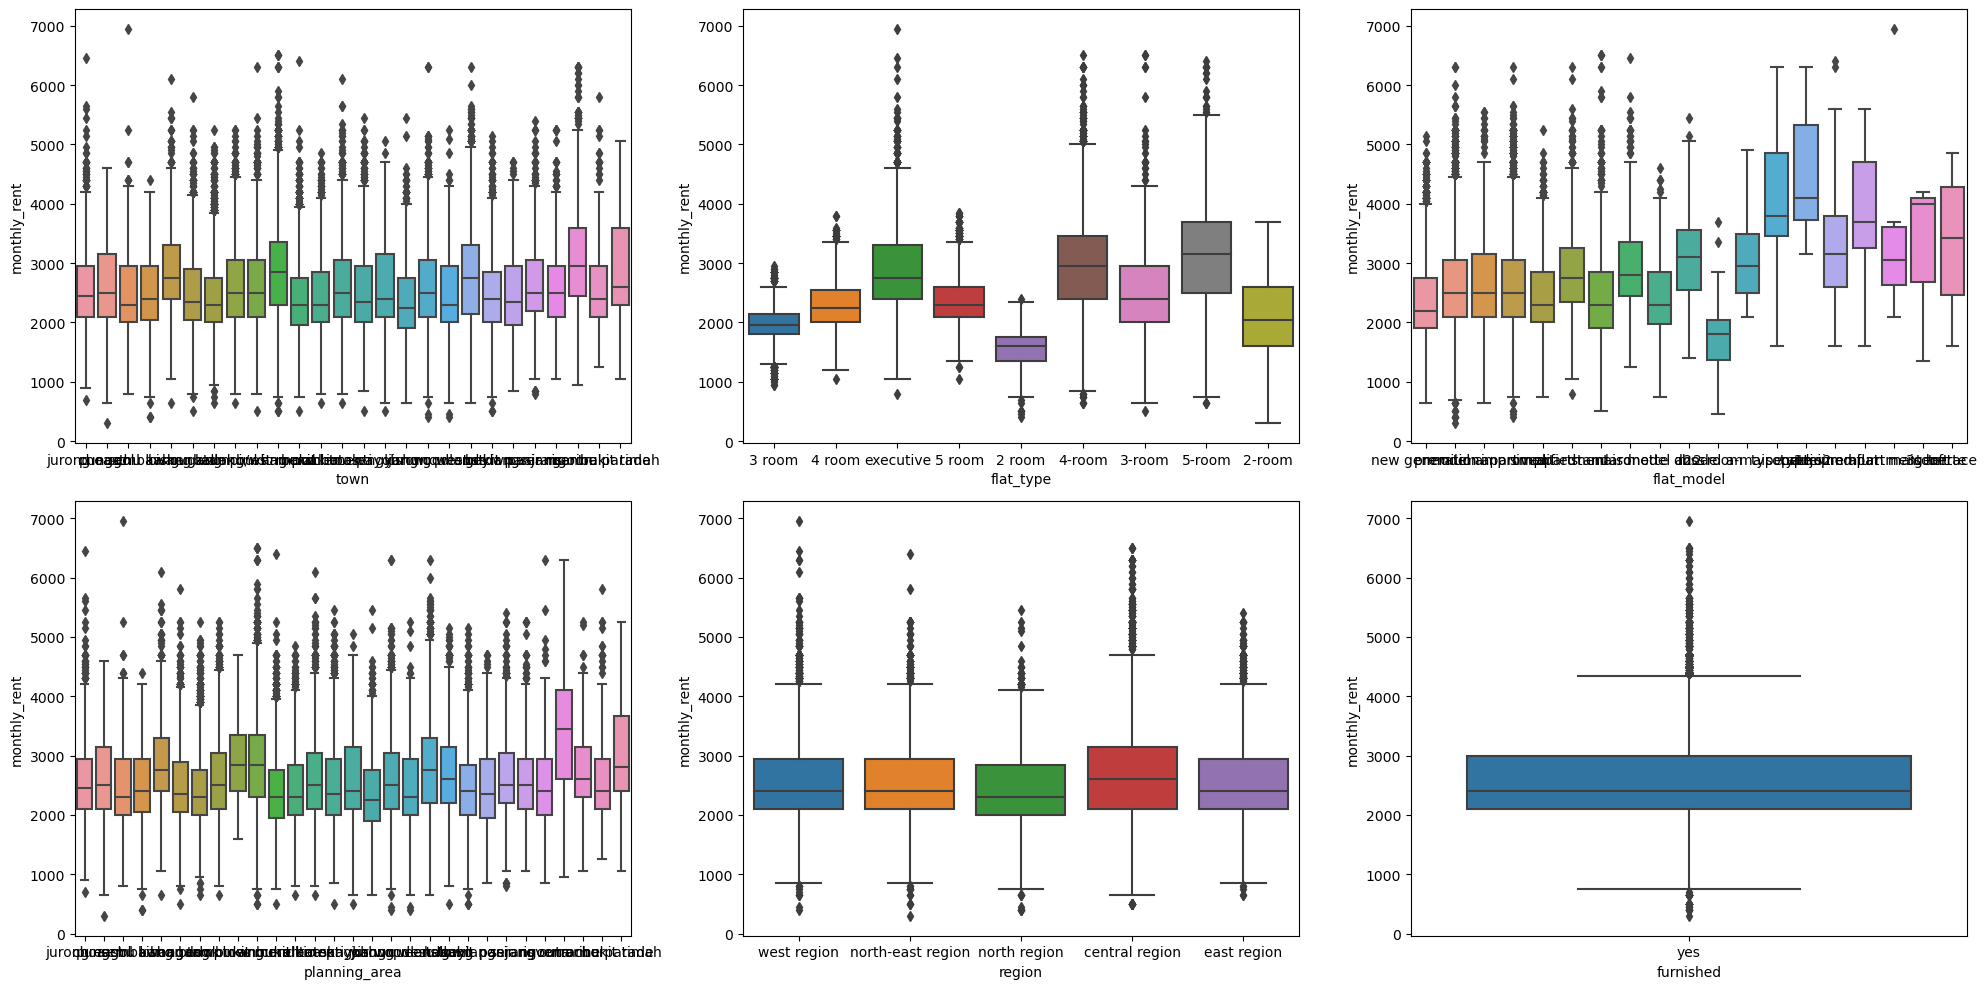

In [33]:
#draw distribution for categorical variables and monthly rent
#town	street_name	flat_type	flat_model	subzone	planning_area	region
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
sns.boxplot(x='town', y='monthly_rent', data=df_train, ax=ax[0, 0])
sns.boxplot(x='flat_type', y='monthly_rent', data=df_train, ax=ax[0, 1])
sns.boxplot(x='flat_model', y='monthly_rent', data=df_train, ax=ax[0, 2])
sns.boxplot(x='planning_area', y='monthly_rent', data=df_train, ax=ax[1, 0])
sns.boxplot(x='region', y='monthly_rent', data=df_train, ax=ax[1, 1])
sns.boxplot(x='furnished', y='monthly_rent', data=df_train, ax=ax[1, 2])
plt.tight_layout()



In [94]:
#remove '-'
df_train['flat_type'] = df_train['flat_type'].str.replace('-', ' ')
df_train['flat_model'] = df_train['flat_model'].str.replace('-', ' ')

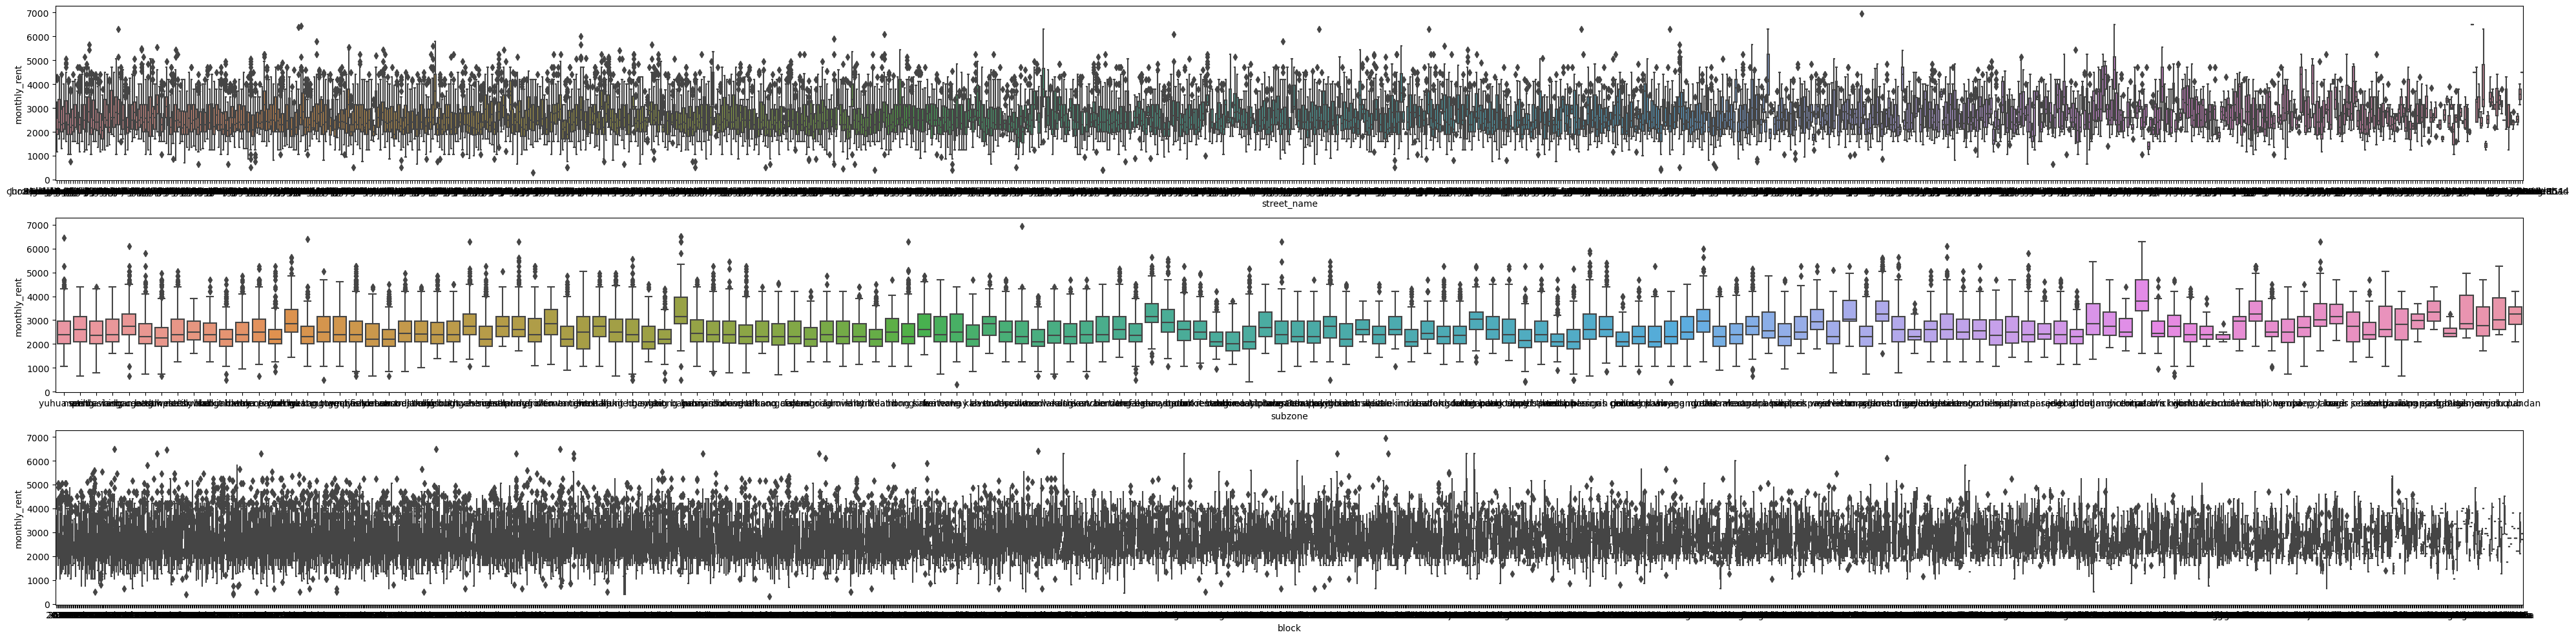

In [35]:
fig, ax = plt.subplots(3, 1, figsize=(40, 10))
sns.boxplot(x='street_name', y='monthly_rent', data=df_train, ax=ax[0,])
sns.boxplot(x='subzone', y='monthly_rent', data=df_train, ax=ax[1,])
sns.boxplot(x='block', y='monthly_rent', data=df_train, ax=ax[2,])
plt.tight_layout()

In [15]:
#map all categorical variables to the mean of monthly rent
def category_map_mean(df_origin):
    df = df_origin.copy()
    #map town decrease order
    grouby_town = df_train.groupby('town')['monthly_rent'].mean()
    town_map = grouby_town.index
    town_map_dict = {town_map[i]: grouby_town[town_map[i]] for i in range(len(town_map))}
    df['town'] = df['town'].apply(lambda x: town_map_dict[x] if x in town_map_dict else grouby_town.mean())

    #map block decrease order
    grouby_block = df_train.groupby('block')['monthly_rent'].mean()
    block_map = grouby_block.index
    block_map_dict = {block_map[i]: grouby_block[block_map[i]] for i in range(len(block_map))}
    df['block'] = df['block'].apply(lambda x: block_map_dict[x] if x in block_map_dict else grouby_block.mean())

    #map flat_type decrease order
    grouby_flat_type = df_train.groupby('flat_type')['monthly_rent'].mean()
    flat_type_map = grouby_flat_type.index
    flat_type_map_dict = {flat_type_map[i]: grouby_flat_type[flat_type_map[i]] for i in range(len(flat_type_map))}
    df['flat_type'] = df['flat_type'].apply(lambda x: flat_type_map_dict[x] if x in flat_type_map_dict else grouby_flat_type.mean())

    #map flat_model decrease order
    grouby_flat_model = df_train.groupby('flat_model')['monthly_rent'].mean()
    flat_model_map = grouby_flat_model.index
    flat_model_map_dict = {flat_model_map[i]: grouby_flat_model[flat_model_map[i]] for i in range(len(flat_model_map))}
    df['flat_model'] = df['flat_model'].apply(lambda x: flat_model_map_dict[x] if x in flat_model_map_dict else grouby_flat_model.mean())

    #map planning_area decrease order
    grouby_planning_area = df_train.groupby('planning_area')['monthly_rent'].mean()
    planning_area_map = grouby_planning_area.index
    planning_area_map_dict = {planning_area_map[i]: grouby_planning_area[planning_area_map[i]] for i in range(len(planning_area_map))}
    df['planning_area'] = df['planning_area'].apply(lambda x: planning_area_map_dict[x] if x in planning_area_map_dict else grouby_planning_area.mean())

    #map region decrease order
    grouby_region = df_train.groupby('region')['monthly_rent'].mean()
    region_map = grouby_region.index
    region_map_dict = {region_map[i]: grouby_region[region_map[i]] for i in range(len(region_map))}
    df['region'] = df['region'].apply(lambda x: region_map_dict[x] if x in region_map_dict else grouby_region.mean())

    #map street_name decrease order
    grouby_street_name = df_train.groupby('street_name')['monthly_rent'].mean()
    street_name_map = grouby_street_name.index
    street_name_map_dict = {street_name_map[i]: grouby_street_name[street_name_map[i]] for i in range(len(street_name_map))}
    df['street_name'] = df['street_name'].apply(lambda x: street_name_map_dict[x] if x in street_name_map_dict else grouby_street_name.mean())

    #map subzone decrease order
    grouby_subzone = df_train.groupby('subzone')['monthly_rent'].mean()
    subzone_map = grouby_subzone.index
    subzone_map_dict = {subzone_map[i]: grouby_subzone[subzone_map[i]] for i in range(len(subzone_map))}
    df['subzone'] = df['subzone'].apply(lambda x: subzone_map_dict[x] if x in subzone_map_dict else grouby_subzone.mean())

    #map rent_approval_date decrease order
    grouby_rent_approval_date = df_train.groupby('rent_approval_date')['monthly_rent'].mean()
    rent_approval_date_map = grouby_rent_approval_date.index
    rent_approval_date_map_dict = {rent_approval_date_map[i]: grouby_rent_approval_date[rent_approval_date_map[i]] for i in range(len(rent_approval_date_map))}
    df['rent_approval_date_mean'] = df['rent_approval_date'].apply(lambda x: rent_approval_date_map_dict[x] if x in rent_approval_date_map_dict else grouby_rent_approval_date.mean())

    
    

    return df

In [16]:
df_train_map_mean = category_map_mean(df_train)
df_train_map_mean.drop(['elevation'], axis=1, inplace=True)
df_train_map_mean.drop(['furnished'], axis=1, inplace=True)
df_train_map_mean.drop(['rent_approval_date'], axis=1, inplace=True)
#df_train_map_mean.drop(['latitude'], axis=1, inplace=True)
#df_train_map_mean.drop(['longitude'], axis=1, inplace=True)
df_train_map_mean

,town,block,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,subzone,planning_area,region,monthly_rent,rent_approval_date_mean
0,2595.146199,2464.285714,2282.692308,1974.144364,2369.965462,67.0,1983,1.344518,103.738630,2542.158516,2595.146199,2569.167537,1600,2233.926780
1,2438.227223,2357.720588,2384.124088,2967.274143,2369.965462,92.0,1978,1.330186,103.938717,2360.371046,2438.227223,2570.667785,2250,2517.128874
2,2516.680515,2428.873239,2402.484472,2486.934831,2636.211052,67.0,1971,1.332242,103.845643,2808.893871,2516.680515,2737.201353,1900,2928.483245
3,2686.857477,2375.714286,2691.237113,2892.857143,2878.725962,149.0,1993,1.370239,103.962894,2610.338573,2686.857477,2570.667785,2850,2249.901768
4,2665.537634,2470.681818,2261.363636,2486.934831,2636.211052,68.0,1972,1.320502,103.863341,2793.525180,2702.635659,2737.201353,2100,2986.739659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2416.700057,2505.714286,2368.501529,1974.144364,2369.965462,67.0,1979,1.366050,103.854168,2390.887097,2416.700057,2558.822710,2200,2233.926780
59996,2904.113924,3850.000000,3512.500000,2967.274143,2612.031305,83.0,2019,1.286493,103.821434,2694.936709,2904.113924,2737.201353,4100,3178.128128
59997,2638.489123,2900.000000,2552.564103,3119.093149,2636.211052,122.0,1988,1.355064,103.936507,2602.823315,2638.489123,2570.667785,2250,2582.606383
59998,2438.227223,2566.981132,2570.967742,3119.093149,2444.223986,123.0,1977,1.318974,103.944076,2434.379786,2438.227223,2570.667785,4700,3069.581639


Index(['town', 'block', 'street_name', 'flat_type', 'flat_model',
       'floor_area_sqm', 'lease_commence_date', 'latitude', 'longitude',
       'subzone', 'planning_area', 'region', 'monthly_rent', 'adjusted_close',
       'price', 'bids_quota_ratio', 'rent_approval_year',
       'rent_approval_month', 'rent_approval_date_mean'],
      dtype='object')

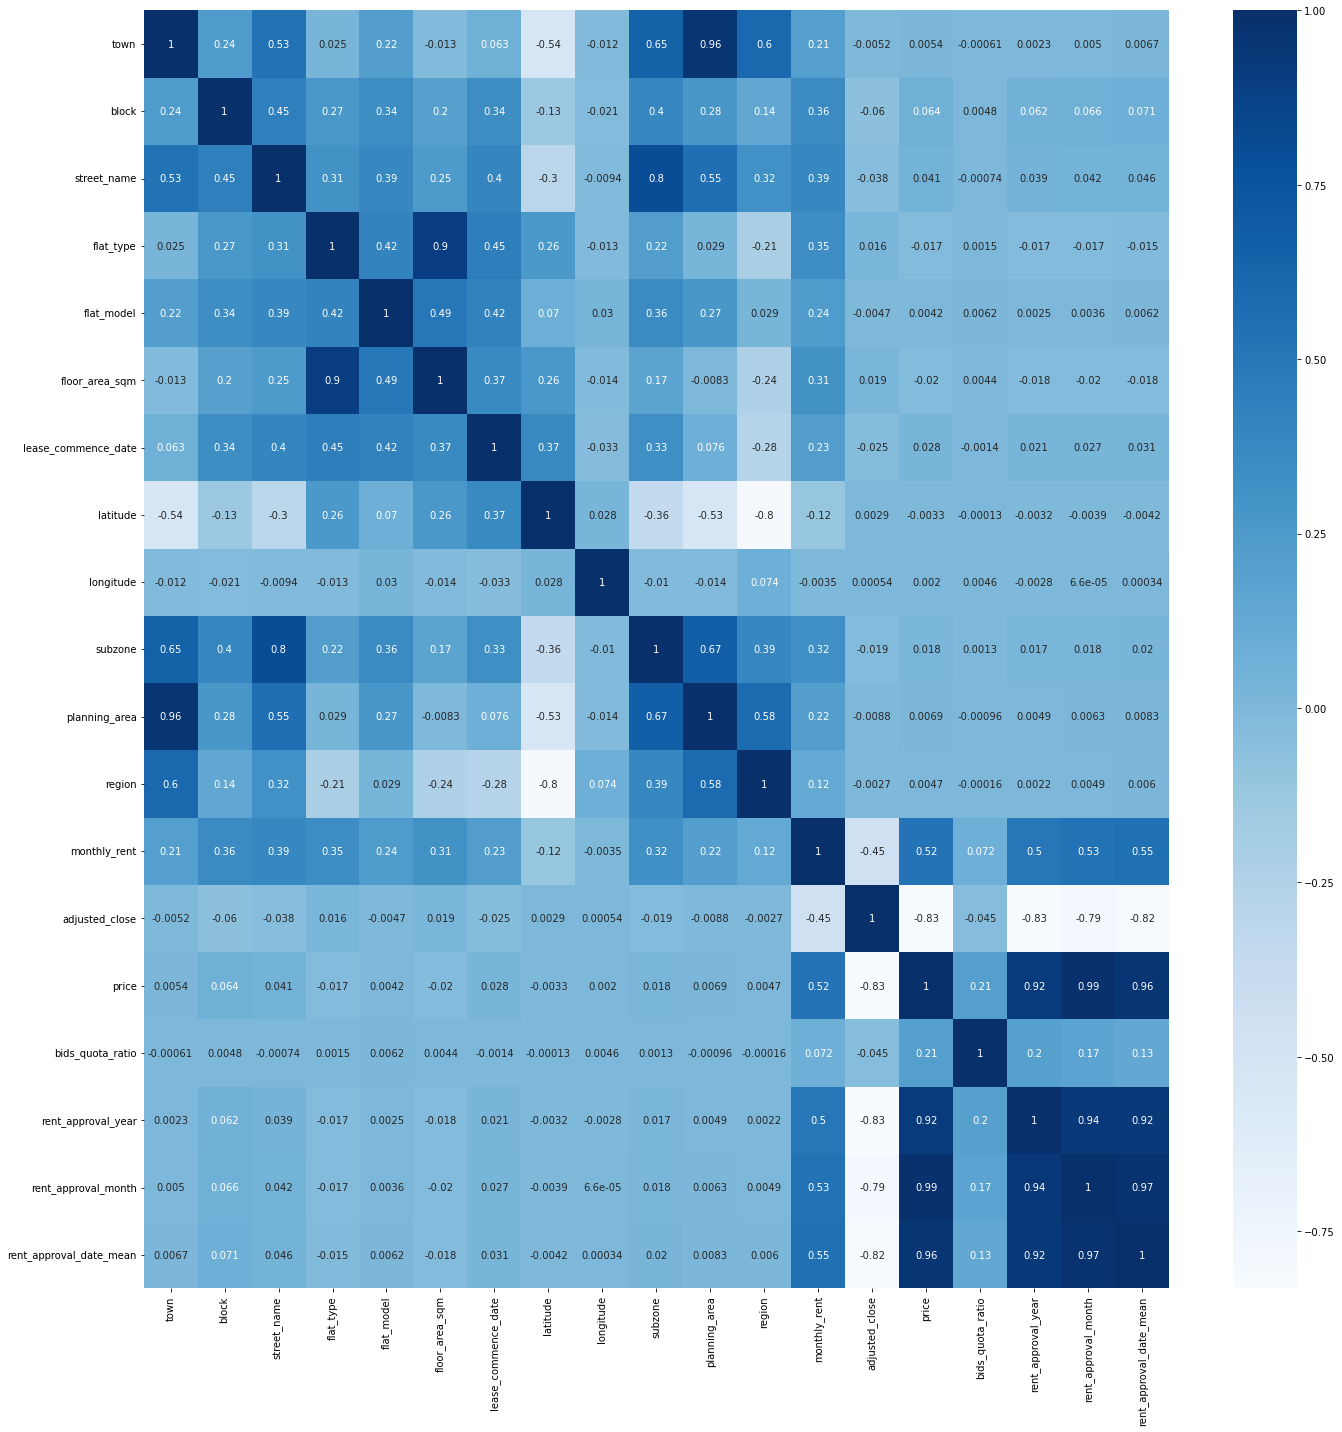

In [97]:
plt.figure(figsize=(20, 20))
corr = df_train_map_mean.corr()
sns.heatmap(corr, annot=True, cmap='Blues')
plt.tight_layout()
df_train_map_mean.columns

In [39]:
#draw latitude and longitude on map
import nbformat
print(nbformat.__version__)
fig = px.scatter_geo(df_train_map_mean[:10000], lat='latitude', lon='longitude', color='monthly_rent', hover_name='block', projection='natural earth')
fig.show()


5.9.2


## try with attributes > 0.3
* block
* street_name
* flat_type
* floor_area_sqm
* subzone
* rent_approval_date_mean
* price
## with method
* xgboost
* lgbm

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [150]:
def data_preprocess(df):
    df = df.copy()
    df_coe = pd.read_csv(path_prefix + 'auxiliary-data/auxiliary-data/sg-coe-prices.csv')
    month_to_numeric = {
        'january': 1,
        'february': 2,
        'march': 3,
        'april': 4,
        'may': 5,
        'june': 6,
        'july': 7,
        'august': 8,
        'september': 9,
        'october': 10,
        'november': 11,
        'december': 12
    }

    df_coe['month'] = df_coe['month'].apply(lambda x: month_to_numeric[x.lower()])
    df_coe['month'] = df_coe['month'].apply(lambda x: f'{x:02d}')

    df_coe['date'] = df_coe['year'].astype(str) + '-' + df_coe['month']
    df_coe = df_coe[['date', 'price']]
    avg_price_bids_quota = df_coe.groupby('date').mean().reset_index()

    df['price'] = df['rent_approval_date'].apply(lambda x: avg_price_bids_quota[avg_price_bids_quota['date'] == x]['price'].values[0])

    df['flat_type'] = df['flat_type'].str.replace('-', ' ')
    df = category_map_mean(df)
    df.drop(['elevation'], axis=1, inplace=True)
    df.drop(['furnished'], axis=1, inplace=True)
    df.drop(['latitude'], axis=1, inplace=True)
    df.drop(['longitude'], axis=1, inplace=True)
    df['rent_date'] = pd.to_datetime(df['rent_approval_date']).dt.year + pd.to_datetime(df['rent_approval_date']).dt.month/12
    df.drop(['rent_approval_date'], axis=1, inplace=True)
    
    df = df[['block', 'street_name', 'flat_type', 'town', 'floor_area_sqm', 'planning_area','subzone', 'rent_approval_date_mean', 'price','rent_date']]
    return df

In [151]:
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')

In [152]:
df_train

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021-09,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1979,1.366050,103.854168,0.0,chong boon,ang mo kio,north-east region,2200
59996,2023-04,bukit merah,95a,henderson road,4-room,model a,83.0,yes,2019,1.286493,103.821434,0.0,henderson hill,bukit merah,central region,4100
59997,2022-06,tampines,862a,tampines street 83,5-room,improved,122.0,yes,1988,1.355064,103.936507,0.0,tampines west,tampines,east region,2250
59998,2023-01,bedok,67,Bedok Sth Avenue 3,5-room,standard,123.0,yes,1977,1.318974,103.944076,0.0,bedok south,bedok,east region,4700


In [153]:
#count test data has block in train data
df_train_block = df_train['block'].unique()
print(len(df_train_block))
df_test_block = df_test['block']
count = 0
for i in range(len(df_test_block)):
    if df_test_block[i] in df_train_block:
        count += 1
print(count)

2553
29921


In [154]:
df_train_X = data_preprocess(df_train)
#df_train_X = df_train_X.drop(['monthly_rent'], axis=1)
df_train_y = df_train['monthly_rent']
df_test_X = data_preprocess(df_test)
df_test_X

,block,street_name,flat_type,town,floor_area_sqm,planning_area,subzone,rent_approval_date_mean,price,rent_date
0,2625.000000,2375.000000,2400.673617,2503.252886,121.0,2503.252886,2427.604167,3069.581639,92845.000,2023.083333
1,2522.916667,2616.666667,2302.270969,2540.491010,100.0,2540.491010,2592.332790,2812.587413,92942.625,2022.750000
2,2700.000000,2567.261905,2302.270969,2646.808979,91.0,2646.808979,2395.588235,3262.248898,104442.375,2023.583333
3,2515.333333,2829.629630,1974.144364,2595.146199,74.0,2595.146199,2400.150150,2249.901768,51997.375,2021.666667
4,2610.215054,2280.416667,2400.673617,2595.146199,121.0,2595.146199,2400.150150,2449.322430,79016.000,2022.250000
...,...,...,...,...,...,...,...,...,...,...
29995,2766.666667,2568.143460,2302.270969,2665.555556,92.0,2665.555556,2654.294479,2755.309735,90883.875,2022.666667
29996,2178.947368,2388.732394,2302.270969,2540.491010,90.0,2540.491010,2473.678647,3103.949406,98624.125,2023.166667
29997,2464.035088,2264.655172,1974.144364,2416.700057,68.0,2416.700057,2378.606965,3189.212679,103440.750,2023.416667
29998,2946.153846,2526.829268,2892.857143,2466.298251,144.0,2466.298251,2497.040971,3103.949406,98624.125,2023.166667


In [155]:
df_train_X

,block,street_name,flat_type,town,floor_area_sqm,planning_area,subzone,rent_approval_date_mean,price,rent_date
0,2464.285714,2282.692308,1974.144364,2595.146199,67.0,2595.146199,2542.158516,2233.926780,54951.625,2021.750000
1,2357.720588,2384.124088,2302.270969,2438.227223,92.0,2438.227223,2360.371046,2517.128874,77035.625,2022.416667
2,2428.873239,2402.484472,1974.144364,2516.680515,67.0,2516.680515,2808.893871,2928.483245,89580.250,2022.833333
3,2375.714286,2691.237113,2892.857143,2686.857477,149.0,2686.857477,2610.338573,2249.901768,51997.375,2021.666667
4,2470.681818,2261.363636,1974.144364,2665.537634,68.0,2702.635659,2793.525180,2986.739659,99472.875,2022.916667
...,...,...,...,...,...,...,...,...,...,...
59995,2505.714286,2368.501529,1974.144364,2416.700057,67.0,2416.700057,2390.887097,2233.926780,54951.625,2021.750000
59996,3850.000000,3512.500000,2302.270969,2904.113924,83.0,2904.113924,2694.936709,3178.128128,104404.750,2023.333333
59997,2900.000000,2552.564103,2400.673617,2638.489123,122.0,2638.489123,2602.823315,2582.606383,83323.125,2022.500000
59998,2566.981132,2570.967742,2400.673617,2438.227223,123.0,2438.227223,2434.379786,3069.581639,92845.000,2023.083333


In [156]:
from scipy import stats

z_scores = stats.zscore(df_train_X)

threshold = 3

outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
print(len(outlier_indices))

df_train_X = df_train_X.drop(outlier_indices)
df_train_y = df_train_y.drop(outlier_indices)

df_train_X.reset_index(drop=True, inplace=True)
df_train_y.reset_index(drop=True, inplace=True)

print(df_train_X)

4569
             block  street_name    flat_type         town  floor_area_sqm  \
0      2464.285714  2282.692308  1974.144364  2595.146199            67.0   
1      2357.720588  2384.124088  2302.270969  2438.227223            92.0   
2      2428.873239  2402.484472  1974.144364  2516.680515            67.0   
3      2375.714286  2691.237113  2892.857143  2686.857477           149.0   
4      2470.681818  2261.363636  1974.144364  2665.537634            68.0   
...            ...          ...          ...          ...             ...   
57076  2393.181818  2569.047619  1974.144364  2484.265734            68.0   
57077  2505.714286  2368.501529  1974.144364  2416.700057            67.0   
57078  2900.000000  2552.564103  2400.673617  2638.489123           122.0   
57079  2566.981132  2570.967742  2400.673617  2438.227223           123.0   
57080  2360.714286  2368.501529  1974.144364  2416.700057            67.0   

       planning_area      subzone  rent_approval_date_mean      price 

In [157]:
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [158]:
#cut 30% data as validation set
X_train, X_val, y_train, y_val = train_test_split(df_train_X, df_train_y, test_size=0.3, random_state=19260817)

In [121]:
# =============== model based on year ================== #

In [147]:
features = ['block', 'street_name', 'flat_type', 'town', 'floor_area_sqm',
            'planning_area', 'subzone', 'rent_approval_date_mean', 'price', 'rent_date']

In [161]:
X_train['rent_date'].astype(int).unique()

array([2021, 2022, 2023])

In [184]:
model = []
for i in X_train['rent_date'].astype(int).unique():
    idx = X_train[X_train['rent_date'].astype(int) == i].index
    X_train_ = X_train.loc[idx].copy()
    y_train_ = y_train.loc[idx].copy()
    LGBM = LGBMRegressor(
        learning_rate=0.01,
        n_estimators=1000,
    )
    LGBM.fit(X_train_, y_train_)
    model.append(LGBM)

In [ ]:
y_pred = []
for index, row in X_val.iterrows():
    LGBM = model[X_val.loc[index, 'rent_date'].astype(int) - 2021]
    input_data = pd.DataFrame({feature: [row[feature]] for feature in features})

    y_pred_ = LGBM.predict(input_data)
    print(index)
    y_pred.extend(y_pred_)

In [187]:
print('LGBM MAE: ', mean_absolute_error(y_val, y_pred))
print('LGBM RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
# df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
# df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
# df_plot_diff['diff'].hist(bins=100)

LGBM MAE:  364.7990720993586
LGBM RMSE:  480.5433629165033


In [194]:
#make submission
model = []
for i in df_train_X['rent_date'].astype(int).unique():
    idx = df_train_X[df_train_X['rent_date'].astype(int) == i].index
    X_train_ = df_train_X.loc[idx].copy()
    y_train_ = df_train_y.loc[idx].copy()
    LGBM = LGBMRegressor(
        learning_rate=0.01,
        n_estimators=1000,
    )
    LGBM.fit(X_train_, y_train_)
    model.append(LGBM)

In [199]:
y_pred = []
for index, row in df_test_X.iterrows():
    LGBM = model[df_test_X.loc[index, 'rent_date'].astype(int) - 2021]
    input_data = pd.DataFrame({feature: [row[feature]] for feature in features})

    y_pred_ = LGBM.predict(input_data)
    print(index)
    y_pred.extend(y_pred_)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149


3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817


5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553


7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208


8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887


10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
1045

11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
11825
11826
11827
11828
11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
11845
11846
1184

13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
1323

14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
14556
14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
14623
14624
14625
14626
14627
14628
14629
14630
14631
14632
14633
14634
14635
1463

15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006
16007
16008
16009
16010
16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
1603

17259
17260
17261
17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273
17274
17275
17276
17277
17278
17279
17280
17281
17282
17283
17284
17285
17286
17287
17288
17289
17290
17291
17292
17293
17294
17295
17296
17297
17298
17299
17300
17301
17302
17303
17304
17305
17306
17307
17308
17309
17310
17311
17312
17313
17314
17315
17316
17317
17318
17319
17320
17321
17322
17323
17324
17325
17326
17327
17328
17329
17330
17331
17332
17333
17334
17335
17336
17337
17338
17339
17340
17341
17342
17343
17344
17345
17346
17347
17348
17349
17350
17351
17352
17353
17354
17355
17356
17357
17358
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368
17369
17370
17371
17372
17373
17374
17375
17376
17377
17378
17379
17380
17381
17382
17383
17384
17385
17386
17387
17388
17389
17390
17391
17392
17393
17394
17395
17396
17397
17398
17399
17400
17401
17402
17403
17404
17405
17406
17407
17408
17409
17410
17411
17412
17413
17414
17415
17416
17417
17418
17419
17420
17421
17422
17423
17424
1742

18657
18658
18659
18660
18661
18662
18663
18664
18665
18666
18667
18668
18669
18670
18671
18672
18673
18674
18675
18676
18677
18678
18679
18680
18681
18682
18683
18684
18685
18686
18687
18688
18689
18690
18691
18692
18693
18694
18695
18696
18697
18698
18699
18700
18701
18702
18703
18704
18705
18706
18707
18708
18709
18710
18711
18712
18713
18714
18715
18716
18717
18718
18719
18720
18721
18722
18723
18724
18725
18726
18727
18728
18729
18730
18731
18732
18733
18734
18735
18736
18737
18738
18739
18740
18741
18742
18743
18744
18745
18746
18747
18748
18749
18750
18751
18752
18753
18754
18755
18756
18757
18758
18759
18760
18761
18762
18763
18764
18765
18766
18767
18768
18769
18770
18771
18772
18773
18774
18775
18776
18777
18778
18779
18780
18781
18782
18783
18784
18785
18786
18787
18788
18789
18790
18791
18792
18793
18794
18795
18796
18797
18798
18799
18800
18801
18802
18803
18804
18805
18806
18807
18808
18809
18810
18811
18812
18813
18814
18815
18816
18817
18818
18819
18820
18821
18822
1882

20041
20042
20043
20044
20045
20046
20047
20048
20049
20050
20051
20052
20053
20054
20055
20056
20057
20058
20059
20060
20061
20062
20063
20064
20065
20066
20067
20068
20069
20070
20071
20072
20073
20074
20075
20076
20077
20078
20079
20080
20081
20082
20083
20084
20085
20086
20087
20088
20089
20090
20091
20092
20093
20094
20095
20096
20097
20098
20099
20100
20101
20102
20103
20104
20105
20106
20107
20108
20109
20110
20111
20112
20113
20114
20115
20116
20117
20118
20119
20120
20121
20122
20123
20124
20125
20126
20127
20128
20129
20130
20131
20132
20133
20134
20135
20136
20137
20138
20139
20140
20141
20142
20143
20144
20145
20146
20147
20148
20149
20150
20151
20152
20153
20154
20155
20156
20157
20158
20159
20160
20161
20162
20163
20164
20165
20166
20167
20168
20169
20170
20171
20172
20173
20174
20175
20176
20177
20178
20179
20180
20181
20182
20183
20184
20185
20186
20187
20188
20189
20190
20191
20192
20193
20194
20195
20196
20197
20198
20199
20200
20201
20202
20203
20204
20205
20206
2020

21440
21441
21442
21443
21444
21445
21446
21447
21448
21449
21450
21451
21452
21453
21454
21455
21456
21457
21458
21459
21460
21461
21462
21463
21464
21465
21466
21467
21468
21469
21470
21471
21472
21473
21474
21475
21476
21477
21478
21479
21480
21481
21482
21483
21484
21485
21486
21487
21488
21489
21490
21491
21492
21493
21494
21495
21496
21497
21498
21499
21500
21501
21502
21503
21504
21505
21506
21507
21508
21509
21510
21511
21512
21513
21514
21515
21516
21517
21518
21519
21520
21521
21522
21523
21524
21525
21526
21527
21528
21529
21530
21531
21532
21533
21534
21535
21536
21537
21538
21539
21540
21541
21542
21543
21544
21545
21546
21547
21548
21549
21550
21551
21552
21553
21554
21555
21556
21557
21558
21559
21560
21561
21562
21563
21564
21565
21566
21567
21568
21569
21570
21571
21572
21573
21574
21575
21576
21577
21578
21579
21580
21581
21582
21583
21584
21585
21586
21587
21588
21589
21590
21591
21592
21593
21594
21595
21596
21597
21598
21599
21600
21601
21602
21603
21604
21605
2160

22831
22832
22833
22834
22835
22836
22837
22838
22839
22840
22841
22842
22843
22844
22845
22846
22847
22848
22849
22850
22851
22852
22853
22854
22855
22856
22857
22858
22859
22860
22861
22862
22863
22864
22865
22866
22867
22868
22869
22870
22871
22872
22873
22874
22875
22876
22877
22878
22879
22880
22881
22882
22883
22884
22885
22886
22887
22888
22889
22890
22891
22892
22893
22894
22895
22896
22897
22898
22899
22900
22901
22902
22903
22904
22905
22906
22907
22908
22909
22910
22911
22912
22913
22914
22915
22916
22917
22918
22919
22920
22921
22922
22923
22924
22925
22926
22927
22928
22929
22930
22931
22932
22933
22934
22935
22936
22937
22938
22939
22940
22941
22942
22943
22944
22945
22946
22947
22948
22949
22950
22951
22952
22953
22954
22955
22956
22957
22958
22959
22960
22961
22962
22963
22964
22965
22966
22967
22968
22969
22970
22971
22972
22973
22974
22975
22976
22977
22978
22979
22980
22981
22982
22983
22984
22985
22986
22987
22988
22989
22990
22991
22992
22993
22994
22995
22996
2299

24231
24232
24233
24234
24235
24236
24237
24238
24239
24240
24241
24242
24243
24244
24245
24246
24247
24248
24249
24250
24251
24252
24253
24254
24255
24256
24257
24258
24259
24260
24261
24262
24263
24264
24265
24266
24267
24268
24269
24270
24271
24272
24273
24274
24275
24276
24277
24278
24279
24280
24281
24282
24283
24284
24285
24286
24287
24288
24289
24290
24291
24292
24293
24294
24295
24296
24297
24298
24299
24300
24301
24302
24303
24304
24305
24306
24307
24308
24309
24310
24311
24312
24313
24314
24315
24316
24317
24318
24319
24320
24321
24322
24323
24324
24325
24326
24327
24328
24329
24330
24331
24332
24333
24334
24335
24336
24337
24338
24339
24340
24341
24342
24343
24344
24345
24346
24347
24348
24349
24350
24351
24352
24353
24354
24355
24356
24357
24358
24359
24360
24361
24362
24363
24364
24365
24366
24367
24368
24369
24370
24371
24372
24373
24374
24375
24376
24377
24378
24379
24380
24381
24382
24383
24384
24385
24386
24387
24388
24389
24390
24391
24392
24393
24394
24395
24396
2439

25621
25622
25623
25624
25625
25626
25627
25628
25629
25630
25631
25632
25633
25634
25635
25636
25637
25638
25639
25640
25641
25642
25643
25644
25645
25646
25647
25648
25649
25650
25651
25652
25653
25654
25655
25656
25657
25658
25659
25660
25661
25662
25663
25664
25665
25666
25667
25668
25669
25670
25671
25672
25673
25674
25675
25676
25677
25678
25679
25680
25681
25682
25683
25684
25685
25686
25687
25688
25689
25690
25691
25692
25693
25694
25695
25696
25697
25698
25699
25700
25701
25702
25703
25704
25705
25706
25707
25708
25709
25710
25711
25712
25713
25714
25715
25716
25717
25718
25719
25720
25721
25722
25723
25724
25725
25726
25727
25728
25729
25730
25731
25732
25733
25734
25735
25736
25737
25738
25739
25740
25741
25742
25743
25744
25745
25746
25747
25748
25749
25750
25751
25752
25753
25754
25755
25756
25757
25758
25759
25760
25761
25762
25763
25764
25765
25766
25767
25768
25769
25770
25771
25772
25773
25774
25775
25776
25777
25778
25779
25780
25781
25782
25783
25784
25785
25786
2578

27013
27014
27015
27016
27017
27018
27019
27020
27021
27022
27023
27024
27025
27026
27027
27028
27029
27030
27031
27032
27033
27034
27035
27036
27037
27038
27039
27040
27041
27042
27043
27044
27045
27046
27047
27048
27049
27050
27051
27052
27053
27054
27055
27056
27057
27058
27059
27060
27061
27062
27063
27064
27065
27066
27067
27068
27069
27070
27071
27072
27073
27074
27075
27076
27077
27078
27079
27080
27081
27082
27083
27084
27085
27086
27087
27088
27089
27090
27091
27092
27093
27094
27095
27096
27097
27098
27099
27100
27101
27102
27103
27104
27105
27106
27107
27108
27109
27110
27111
27112
27113
27114
27115
27116
27117
27118
27119
27120
27121
27122
27123
27124
27125
27126
27127
27128
27129
27130
27131
27132
27133
27134
27135
27136
27137
27138
27139
27140
27141
27142
27143
27144
27145
27146
27147
27148
27149
27150
27151
27152
27153
27154
27155
27156
27157
27158
27159
27160
27161
27162
27163
27164
27165
27166
27167
27168
27169
27170
27171
27172
27173
27174
27175
27176
27177
27178
2717

28405
28406
28407
28408
28409
28410
28411
28412
28413
28414
28415
28416
28417
28418
28419
28420
28421
28422
28423
28424
28425
28426
28427
28428
28429
28430
28431
28432
28433
28434
28435
28436
28437
28438
28439
28440
28441
28442
28443
28444
28445
28446
28447
28448
28449
28450
28451
28452
28453
28454
28455
28456
28457
28458
28459
28460
28461
28462
28463
28464
28465
28466
28467
28468
28469
28470
28471
28472
28473
28474
28475
28476
28477
28478
28479
28480
28481
28482
28483
28484
28485
28486
28487
28488
28489
28490
28491
28492
28493
28494
28495
28496
28497
28498
28499
28500
28501
28502
28503
28504
28505
28506
28507
28508
28509
28510
28511
28512
28513
28514
28515
28516
28517
28518
28519
28520
28521
28522
28523
28524
28525
28526
28527
28528
28529
28530
28531
28532
28533
28534
28535
28536
28537
28538
28539
28540
28541
28542
28543
28544
28545
28546
28547
28548
28549
28550
28551
28552
28553
28554
28555
28556
28557
28558
28559
28560
28561
28562
28563
28564
28565
28566
28567
28568
28569
28570
2857

29787
29788
29789
29790
29791
29792
29793
29794
29795
29796
29797
29798
29799
29800
29801
29802
29803
29804
29805
29806
29807
29808
29809
29810
29811
29812
29813
29814
29815
29816
29817
29818
29819
29820
29821
29822
29823
29824
29825
29826
29827
29828
29829
29830
29831
29832
29833
29834
29835
29836
29837
29838
29839
29840
29841
29842
29843
29844
29845
29846
29847
29848
29849
29850
29851
29852
29853
29854
29855
29856
29857
29858
29859
29860
29861
29862
29863
29864
29865
29866
29867
29868
29869
29870
29871
29872
29873
29874
29875
29876
29877
29878
29879
29880
29881
29882
29883
29884
29885
29886
29887
29888
29889
29890
29891
29892
29893
29894
29895
29896
29897
29898
29899
29900
29901
29902
29903
29904
29905
29906
29907
29908
29909
29910
29911
29912
29913
29914
29915
29916
29917
29918
29919
29920
29921
29922
29923
29924
29925
29926
29927
29928
29929
29930
29931
29932
29933
29934
29935
29936
29937
29938
29939
29940
29941
29942
29943
29944
29945
29946
29947
29948
29949
29950
29951
29952
2995

In [200]:
submission = pd.read_csv(path_prefix + 'example-submission.csv')
submission['Predicted'] = y_pred

submission.to_csv('submission.csv', index=False)

MAE:  362.9340121820826
RMSE:  477.15874231612617


<AxesSubplot:>

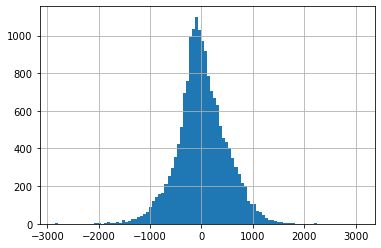

In [22]:
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.01,
    )
xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_val)
print('MAE: ', mean_absolute_error(y_val, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)

In [126]:
#make submission
xgb_regressor = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    )

xgb_regressor.fit(df_train_X, df_train_y)


submission = pd.read_csv(path_prefix + 'example-submission.csv')
submission['Predicted'] = xgb_regressor.predict(df_test_X)

submission.to_csv('submission.csv', index=False)

MAE:  384.70718534905103
RMSE:  509.8019080397552


<AxesSubplot:>

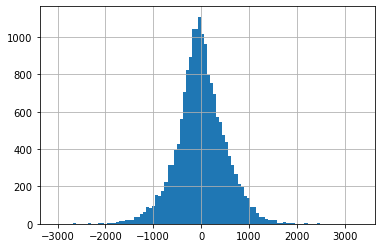

In [109]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

model = DecisionTreeRegressor()
model = RandomForestRegressor()
#model = GradientBoostingRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print('MAE: ', mean_absolute_error(y_val, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)


LGBM MAE:  363.24254149404527
LGBM RMSE:  476.8784051300557


<AxesSubplot:>

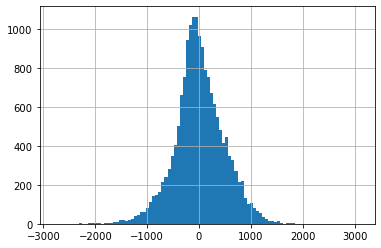

In [92]:
LGBM = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=1000,
)

LGBM.fit(X_train, y_train)
y_pred = LGBM.predict(X_val)
print('LGBM MAE: ', mean_absolute_error(y_val, y_pred))
print('LGBM RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)



In [163]:
#submit with LGBM
LGBM = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=1000,
)

LGBM.fit(df_train_X, df_train_y)

submission = pd.read_csv(path_prefix + 'example-submission.csv')
submission['Predicted'] = LGBM.predict(df_test_X)

submission.to_csv('submission.csv', index=False)



In [46]:
#feature importance
lgb_model = LGBMRegressor()
features = X_train.columns
dict_feature_importance = {}

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_val)

original_rmse = mean_squared_error(y_val, y_pred, squared=False)

for feature in features:
    X_train_tmp = X_train.drop([feature], axis=1)
    X_val_tmp = X_val.drop([feature], axis=1)
    lgb_model.fit(X_train_tmp, y_train)
    y_pred = lgb_model.predict(X_val_tmp)
    dict_feature_importance[feature] = mean_squared_error(y_val, y_pred, squared=False) - original_rmse


In [47]:
for feature in features:
    print(feature, '\t\t', dict_feature_importance[feature])

block 		 6.781290413628653
street_name 		 3.2325207099596582
flat_type 		 0.8867685255146398
floor_area_sqm 		 0.10900175724748351
subzone 		 4.340516944205319
rent_approval_date_mean 		 -0.10558833569683657
adjusted_close 		 -0.4333536304993686
price 		 -0.13245692856355618


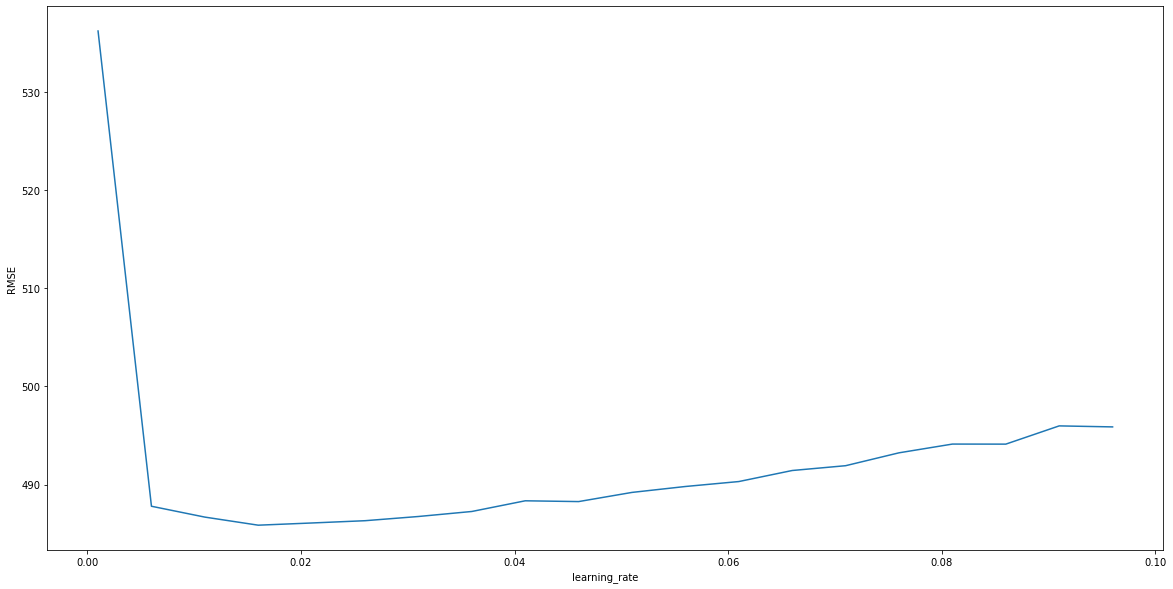

In [48]:
#tuning with different learning rate
learning_rate_list = list(np.arange(0.001, 0.1, 0.005))
LGBM_RMSE_list = []
for learning_rate in learning_rate_list:
    LGBM = LGBMRegressor(
        learning_rate=learning_rate,
        n_estimators=1000,
    )

    LGBM.fit(X_train, y_train)
    y_pred = LGBM.predict(X_val)
    LGBM_RMSE_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))

plt.figure(figsize=(20, 10))
plt.plot(learning_rate_list, LGBM_RMSE_list)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.show()

In [52]:
print(learning_rate_list)
print(LGBM_RMSE_list)

[0.001, 0.006, 0.011, 0.016, 0.021, 0.026000000000000002, 0.031, 0.036000000000000004, 0.041, 0.046, 0.051000000000000004, 0.056, 0.061, 0.066, 0.07100000000000001, 0.076, 0.081, 0.08600000000000001, 0.091, 0.096]
[505.1465763362904, 492.54442895346574, 489.5115007436877, 488.12749381424715, 487.234967598313, 486.43030080137646, 486.5828965446134, 486.6669251273495, 486.63124548097124, 486.7582304233197, 486.6311661213862, 486.47709292086125, 486.510545132065, 486.4096140437656, 486.5259098679828, 486.6720949618832, 486.42651059255394, 486.4040339790541, 486.4040339790541]


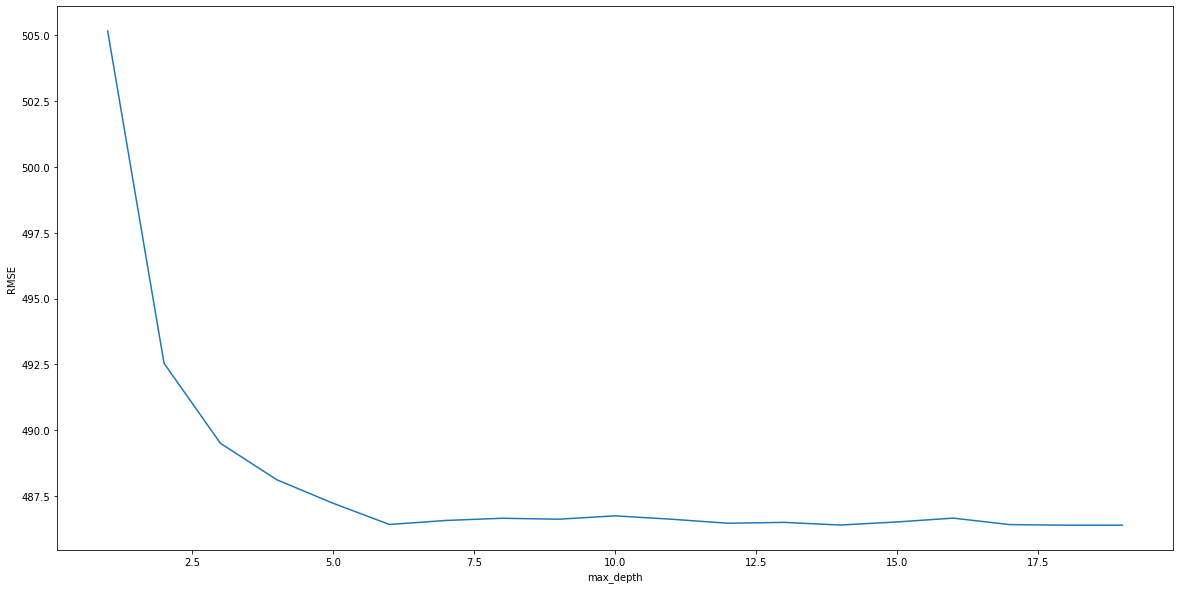

In [49]:
#tuning with different depth
max_depth_list = list(np.arange(1, 20, 1))
LGBM_RMSE_list = []
for max_depth in max_depth_list:
    LGBM = LGBMRegressor(
        learning_rate=0.01,
        n_estimators=1000,
        max_depth=max_depth
    )

    LGBM.fit(X_train, y_train)
    y_pred = LGBM.predict(X_val)
    LGBM_RMSE_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))

plt.figure(figsize=(20, 10))
plt.plot(max_depth_list, LGBM_RMSE_list)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()

In [50]:
#tuning parameters with grid search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': list(np.arange(1, 20, 1)),
    'num_leaves': list(np.arange(2, 100, 1)),
}

LGBM = LGBMRegressor(
    learning_rate=0.01,
)

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))


Fitting 5 folds for each of 1862 candidates, totalling 9310 fits
参数的最佳取值:{'max_depth': 8, 'num_leaves': 99}
最佳模型得分:-525.6642401884303


In [51]:
param_grid = {
    'min_child_samples': list(np.arange(1, 100, 1)),
    'min_child_weight': list(np.arange(0.001, 0.1, 0.001)),
}

LGBM = LGBMRegressor(
    learning_rate=0.01,
    max_depth=grid_search.best_params_['max_depth'],
    num_leaves=grid_search.best_params_['num_leaves'],
)

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))

Fitting 5 folds for each of 9801 candidates, totalling 49005 fits


KeyboardInterrupt: 

In [ ]:
param_grid = {
    'bagging_fraction': list(np.arange(0.5, 1, 0.1)),
    'bagging_freq': list(np.arange(2, 10, 1)),
}

LGBM = LGBMRegressor(
    learning_rate=0.01,
    max_depth=9,
    num_leaves=99,
    min_child_samples=grid_search.best_params_['min_child_samples'],
    min_child_weight=grid_search.best_params_['min_child_weight'],
)

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))

In [ ]:
param_grid = {
    'reg_alpha': list(np.arange(0, 1, 0.1)),
    'reg_lambda': list(np.arange(0, 1, 0.1)),
}

LGBM = LGBMRegressor(
    learning_rate=0.01,
    max_depth=9,
    num_leaves=99,
    min_child_samples=27,
    min_child_weight=0.001,
    bagging_fraction=grid_search.best_params_['bagging_fraction'],
    bagging_freq=grid_search.best_params_['bagging_freq'],
)

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))

In [ ]:
LGBM = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=50000,
    max_depth=9,
    num_leaves=99,
    min_child_samples=27,
    min_child_weight=0.001,
    bagging_fraction=0.5,
    bagging_freq=2,
    reg_alpha=grid_search.best_params_['reg_alpha'],
    reg_lambda=grid_search.best_params_['reg_lambda'],
)

LGBM.fit(X_train, y_train)
y_pred = LGBM.predict(X_val)
print('LGBM MAE: ', mean_absolute_error(y_val, y_pred))
print('LGBM RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)

In [ ]:
xgb = XGBRegressor(
    learning_rate=0.01,
    n_estimators=1000,
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
print('XGB MAE: ', mean_absolute_error(y_val, y_pred))
print('XGB RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)

In [ ]:
#tuning with different learning rate
learning_rate_list = list(np.arange(0.001, 0.02, 0.001))
XGB_RMSE_list = []
for learning_rate in learning_rate_list:
    xgb = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=1000,
    )

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_val)
    XGB_RMSE_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))

plt.plot(learning_rate_list, XGB_RMSE_list)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks


In [ ]:
def build_model(dim, activation='relu', optimizer='adam', loss='mse'):
    model = keras.Sequential([
        layers.Dense(dim, activation=activation, input_shape=[len(df_train_X.columns)]),
        layers.Dense(dim, activation=activation),
        layers.Dense(dim, activation=activation),
        layers.Dense(dim, activation=activation),
        layers.Dense(1, activation='linear')
    ])

    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
model = build_model(1024, activation='softplus', optimizer='adam', loss='mse')

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=10,
)

history = model.fit(
    df_train_X, df_train_y,
    validation_split=0.3,
    epochs=300,
    batch_size=4096,
    callbacks=[early_stopping]
)


Epoch 1/200
12/12 [==============================] - 0s 18ms/step - loss: 242681.7969 - mae: 377.2373 - val_loss: 234221.3594 - val_mae: 369.3957
Epoch 2/200
12/12 [==============================] - 0s 12ms/step - loss: 245132.5938 - mae: 379.5545 - val_loss: 239550.4062 - val_mae: 372.2088
Epoch 3/200
12/12 [==============================] - 0s 15ms/step - loss: 243425.9375 - mae: 377.8757 - val_loss: 241261.1875 - val_mae: 376.8472
Epoch 4/200
12/12 [==============================] - 0s 12ms/step - loss: 240905.5938 - mae: 376.2523 - val_loss: 237150.7656 - val_mae: 373.3318
Epoch 5/200
12/12 [==============================] - 0s 15ms/step - loss: 240885.3594 - mae: 376.0694 - val_loss: 238878.3438 - val_mae: 371.3596
Epoch 6/200
12/12 [==============================] - 0s 12ms/step - loss: 240137.7031 - mae: 375.0016 - val_loss: 236570.2031 - val_mae: 372.2632
Epoch 7/200
12/12 [==============================] - 0s 12ms/step - loss: 241053.8281 - mae: 376.1886 - val_loss: 234648.812